# Designing a Supervised Learning Model  <br>


 - Takes in an input URL of news specific to Pakistan.
 - Designing a text-based model that could extract meaningful information to display to users.
 - Provide suggestions of articles that provide a different viewpoint than the one projected
by the input article

###  Importing Libraries

In [27]:
import json
import newspaper
from newspaper import Article
from time import mktime
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm
import requests
from bs4 import BeautifulSoup
import time
from requests import get
from tqdm import tqdm
from datetime import datetime
import re # To use regular expressions
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import unicodedata
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from textblob import TextBlob
from gensim.models.word2vec import Word2Vec
from nltk import sent_tokenize

### Extracting URL from a webpage
 - The archival data from Pakistan Today was taken regarding Elections 2018.
 - Used BeautifulSoup to parse the html page of the search results of "Elections 2018"
 - Ietrated through first 5 pages of the search results to extract the 85 articles.
 - We extracted the relevant articles using the html tags to find the links of the articles and their content.
 -   The url and title of the articles was appended into a list.

In [3]:
# To extract the URLs from a webpage 
urls = []
title = []
for i in range(1,6):      # Loop through first 5 pages and extract articles 
    url = "https://www.pakistantoday.com.pk/page/{}/?s=elections+2018&submit=Search#038;submit=Search".format(i)
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, 'html.parser')
    title_containers = soup.find_all('div', class_ = 'post-inner')
    for article in title_containers:
        name = article.a.text
        title.append(name)
    for h in soup.find_all('h1'):
        a = h.find('a')
        try:
            if 'href' in a.attrs:
                urls.append(a.attrs['href'])
        except:
            pass

 - We omit every 19th link of the article since there are 19 articles on a single page so whenever we get the articles from a new page the first link is the one which references to that page and not the article itself. 
 - There were 5 of these URL's in total and since they are of no use we omit them.
 - The total entries after discarding these links are 85.

In [4]:
discard = "https://www.pakistantoday.com.pk/"
while discard in urls: 
    urls.remove(discard)   

### Labels
 - Since we are doing supervised learning so we need labels for the 85 articles we collected.
 - The labelling is done manually after reading the articles and splitting them into 2 categories.
 - Biased articles are represented by 1 and unbiased are represented by 0. We chose to represent the unverifies category under the biased articles since there was no way to verify these articles as such.


In [18]:
labels = [0,0,0,1,0,1,0,1,1,0,0,0,0,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,1,1,0,1,1,1,0,0,1,0,1,0,0,0,0,0,
          0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0]
len(labels)

85

### Downloading Articles

In [7]:
content = []
for i in tqdm(urls):
    article = Article(i)
    article.download()
    article.parse()
    content.append(article.text)

100%|██████████| 85/85 [03:42<00:00,  2.51s/it]


In [8]:
print(len(urls))
print(len(title))
print(len(content))

85
85
85


### Creating Dataframe
 - We created a dataframe for all the articles with their title, link, content and respective labels to be later used up in our exploratory data analysis
 

In [24]:
information = {'Title':title, 
        'Link':urls, 
        'Content':content,
        'Labels':labels}
data = pd.DataFrame(data=information)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
Title      85 non-null object
Link       85 non-null object
Content    85 non-null object
Labels     85 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.7+ KB
None


In [25]:
data.head()

,Title,Link,Content,Labels
0,LIVE: By-elections 2018 unofficial results,https://www.pakistantoday.com.pk/2018/10/14/li...,"by News Desk , (Last Updated October 14, 2018)...",0
1,"Elections 2018: Political leaders, prominent p...",https://www.pakistantoday.com.pk/2018/07/25/el...,LAHORE/ISLAMABAD/KARACHI: Several political le...,0
2,Elections 2018: Pak-Afghan borders to remain c...,https://www.pakistantoday.com.pk/2018/07/24/el...,ISLAMABAD: Pakistan’s borders with Afghanistan...,0
3,Elections 2018: Presiding officer from PS-93 a...,https://www.pakistantoday.com.pk/2018/07/23/el...,KARACHI: The Sindh Police on Monday arrested a...,1
4,Elections 2018: ECP encourages women participa...,https://www.pakistantoday.com.pk/2018/07/22/el...,ISLAMABAD: Two provincial chapters of the Elec...,0


#### Storing and Loading data
 - We stored the data into a JSON file to be later loaded into a dataframe whenver we need it.
 - We chose JSON format to store the data since it is easy to use and it is fast in terms of performance.

In [26]:
data.to_json('PT.json')

In [212]:
elections = pd.read_json('PT.json')

In [213]:
elections.head()

,Title,Link,Content,Labels
0,LIVE: By-elections 2018 unofficial results,https://www.pakistantoday.com.pk/2018/10/14/li...,"by News Desk , (Last Updated October 14, 2018)...",0
1,"Elections 2018: Political leaders, prominent p...",https://www.pakistantoday.com.pk/2018/07/25/el...,LAHORE/ISLAMABAD/KARACHI: Several political le...,0
10,Elections 2018: Appellate tribunal rejects Ash...,https://www.pakistantoday.com.pk/2018/06/28/el...,LAHORE: Tehreek-e-Labaik Ya Rasool Allah (TLYR...,0
11,Elections 2018: ECP issues guidelines for medi...,https://www.pakistantoday.com.pk/2018/06/27/el...,ISLAMABAD: The Election Commission of Pakistan...,0
12,Elections 2018: PTI issues tickets to 13 femal...,https://www.pakistantoday.com.pk/2018/06/25/el...,ISLAMABAD: Pakistan Tehreek-e-Insaf (PTI) on M...,0


### Preprocessing
- We converted each preprocessing step into a function
- Used the tutorials from kdnuggets.com to understand text pre-processing

In [214]:
def stem_words(words):
    stemmer = LancasterStemmer()
    words = [stemmer.stem(word) for word in words]
    return words

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    return words

In [217]:
def remove_non_ascii(words):
    words = [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in words]
    return words
# The first pre-processing step which we will do is transform our tweets into lower case.
# This avoids having multiple copies of the same words
def to_lowercase(words):
    words = [word.lower() for word in words]
    return words
# Removing punctuation to reduce the amount of the training data
def remove_punctuation(words):
    words = [re.sub(r'[^\w\s]', '', word) for word in words if re.sub(r'[^\w\s]', '', word) not in '']    
    return words
# Removing numbers from data since they aren't useful in this context.
def replace_numbers(words):
    words = [re.sub(r'[^\w\s]', '', word) for word in words]
    return words
def remove_stopwords(words):
    words = [word for word in words if word not in stopwords.words('english')]
    return words
def remove_date(text):
    """Remove (Date) string"""
    text = re.sub(r'\(.*?\)', '', text)
    return text

In [218]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words

In [219]:
elections['Content'] = elections['Content'].apply(remove_date) 
elections['tokenized_text'] = elections['Content'].apply(word_tokenize) 
elections['tokenized_text'] = elections['tokenized_text'].apply(normalize)

In [15]:
def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems,lemmas
# elections['tokenized_text'].apply(stem_and_lemmatize)

### Data Splitting

In [220]:
train, test = train_test_split(elections, test_size=0.2, random_state=42)
X_train = train['tokenized_text'].values
X_test = test['tokenized_text'].values
y_train = train['Labels']
y_test = test['Labels']
print('X_train',len(X_train))
print('X_test',len(X_test))
print('y_train',len(y_train))
print('y_test',len(X_test))

X_train 68
X_test 17
y_train 68
y_test 17


### Feature Engineering
### Feature 1: TFIDF

In [221]:
def fun(document):
    return document

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=fun,
    preprocessor=fun,
    token_pattern=None)  
tfidf.fit(X_train)
features_train = tfidf.transform(X_train)
features_test = tfidf.transform(X_test)
print(features_train.shape)

(68, 3766)


 - We stored the models and their corresponsing results to visualize them later

In [222]:
models = ['NB','LR','SVM','Tuned-SVM']
accuracies =[] 
mse = []

#### Naive Bayes

In [223]:
model = MultinomialNB().fit(features_train, y_train)
predicted = model.predict(features_test)
print(classification_report(predicted,y_test))
accuracy = model.score(features_test, y_test)
print('Naive Bayes Accuracy',accuracy)
error = mean_squared_error(y_test, predicted)
print('MSE',error)
accuracies.append(accuracy)
mse.append(error)

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      0.53      0.69        17
           1       0.00      0.00      0.00         0

   micro avg       0.53      0.53      0.53        17
   macro avg       0.50      0.26      0.35        17
weighted avg       1.00      0.53      0.69        17

Naive Bayes Accuracy 0.5294117647058824
MSE 0.47058823529411764


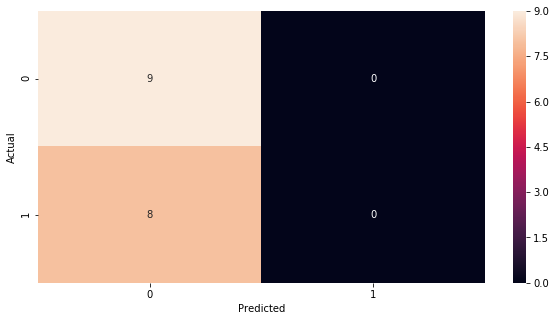

In [225]:
confusion_matrix = cm(y_test, predicted)
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Logistic Regression with SGD
 - We used logistic regression with stochastic gradient descent

In [226]:
final_model= SGDClassifier(loss='log', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
final_model.fit(features_train, y_train)
predicted_svm = final_model.predict(features_test)
accuracy = final_model.score(features_test, y_test)
print(classification_report(predicted_svm,y_test))
error = mean_squared_error(y_test, predicted_svm)
print('Logistic Regression Accuracy',accuracy)
accuracies.append(accuracy)
print('MSE',error)

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.50      0.80      0.62         5

   micro avg       0.71      0.71      0.71        17
   macro avg       0.69      0.73      0.69        17
weighted avg       0.77      0.71      0.72        17

Logistic Regression Accuracy 0.7058823529411765
MSE 0.29411764705882354


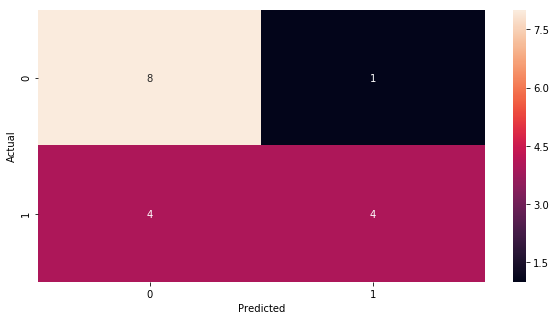

In [227]:
confusion_matrix = cm(y_test, predicted_svm)
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### SVM with SGD

In [228]:
# SVM
model= SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
model.fit(features_train, y_train)
predicted_svm = model.predict(features_test)
print(classification_report(predicted_svm,y_test))
accuracy = model.score(features_test, y_test)
error = mean_squared_error(y_test, predicted_svm)
print('SVM Accuracy',accuracy)
print('MSE',error)
accuracies.append(accuracy)

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.38      0.75      0.50         4

   micro avg       0.65      0.65      0.65        17
   macro avg       0.63      0.68      0.61        17
weighted avg       0.77      0.65      0.67        17

SVM Accuracy 0.6470588235294118
MSE 0.35294117647058826


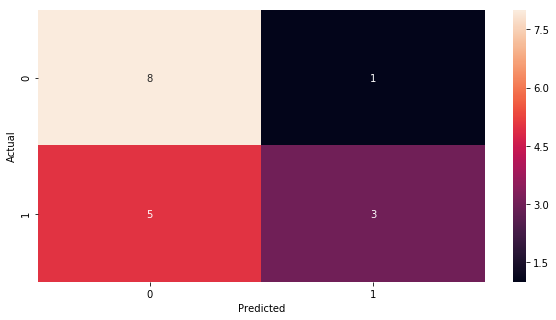

In [229]:
confusion_matrix = cm(y_test, predicted_svm)
# print(confusion_matrix)
# TP FP( FP is Type 1 error)
# FN TN
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### SVM with tuning
 - We used Grid search to find the best hyperparameters for SVM tuning

In [230]:
# SVM with tuning
C = [0.001, 0.01, 0.1, 1, 10]
gamma = [0.001, 0.01, 0.1, 1]
hyperparameters = dict(C=C, gamma=gamma)
clf = GridSearchCV(svm.SVC(kernel='linear'), hyperparameters, cv=5)
best_model = clf.fit(features_train, y_train)
print('Best score',clf.best_score_)
print('Best Parameters',clf.best_params_)
print('Best C:', best_model.best_estimator_.get_params()['C'])
predictions =best_model.best_estimator_.predict(features_test)
accuracy = clf.best_score_
print('Best gamma:', best_model.best_estimator_.get_params()['gamma'])
accuracies.append(accuracy)

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score 0.6911764705882353
Best Parameters {'C': 10, 'gamma': 0.001}
Best C: 10
Best gamma: 0.001


#### Visualization of model results

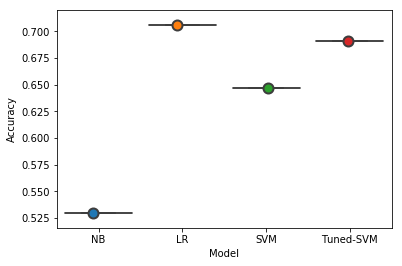

In [231]:
information = {'Model':models, 
        'Accuracy':accuracies}
data = pd.DataFrame(data=information)

sns.boxplot(x='Model', y='Accuracy', data=data)
sns.stripplot(x='Model', y='Accuracy', data=data, size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

 - We can observe from the above plot that logistic regression performs the best when paired with TFIDF
  as feature vector

###  Feature 2: BAG OF WORDS

In [290]:
elections = pd.read_json('PT.json')
elections.head()

,Title,Link,Content,Labels
0,LIVE: By-elections 2018 unofficial results,https://www.pakistantoday.com.pk/2018/10/14/li...,"by News Desk , (Last Updated October 14, 2018)...",0
1,"Elections 2018: Political leaders, prominent p...",https://www.pakistantoday.com.pk/2018/07/25/el...,LAHORE/ISLAMABAD/KARACHI: Several political le...,0
10,Elections 2018: Appellate tribunal rejects Ash...,https://www.pakistantoday.com.pk/2018/06/28/el...,LAHORE: Tehreek-e-Labaik Ya Rasool Allah (TLYR...,0
11,Elections 2018: ECP issues guidelines for medi...,https://www.pakistantoday.com.pk/2018/06/27/el...,ISLAMABAD: The Election Commission of Pakistan...,0
12,Elections 2018: PTI issues tickets to 13 femal...,https://www.pakistantoday.com.pk/2018/06/25/el...,ISLAMABAD: Pakistan Tehreek-e-Insaf (PTI) on M...,0


In [291]:
elections['Content'] = elections['Content'].apply(remove_date) 
elections['tokenized_text'] = elections['Content'].apply(word_tokenize) 

 - Now we see the frequency distribution of the words in the content which lists the top words used in the text which can provide us a rough idea about the topic being discussed in the text.
 - We take only one of the articles and check the frequency distribution of words in it.

In [299]:
tokens = elections['tokenized_text'][0]
vocabulary = set(tokens)
print('Length is:',len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
print(sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:30])

Length is: 348
['.', 'votes', '’', 's', 'with', ':', ',', 'PTI', 'by', 'leads', 'Khan', 'followed', 'in', 'PML-N', 'and', 'results', 'who', 'the', 'by-polls', 'Muhammad', 'unofficial', 'has', 'is', 'Ali', 'Ahmed', 'second', 'won', 'unconfirmed', 'place', 'so']


 - We use wordcloud to create word clouds by placing words on a canvas randomly, with sizes proportional to their frequency in the text.

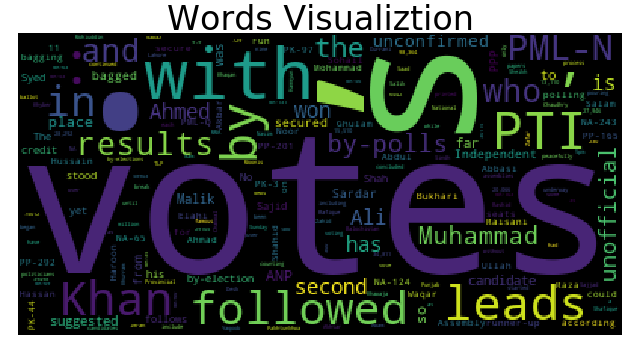

In [300]:
fig = plt.figure(figsize=(20,10), dpi=40)
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.title('Words Visualiztion',fontsize = 60)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Exploration of some random features to know the data
 - Number of words : We extract the number of words in each article. According to research it is said that biased(negative) sentiments usually contain a less amount of words as compared to the unbiased(postive) sentiments.

In [301]:
elections['word_count'] = elections['Content'].apply(lambda x: len(str(x).split(" ")))
elections[['Content','word_count','Labels']].tail()

,Content,word_count,Labels
81,ISLAMABAD – Pakistan is set to become the firs...,193,1
82,Calls for enlisting missing women in voters’ l...,425,0
83,In Sindh party-cum-parochial needs override na...,369,1
84,PESHAWAR: Milli Muslim League chief Professor...,530,0
9,"RAWALPINDI: With the elections, just a few wee...",303,0


 - There is no clear pattern in our data as far as the number of words are concerned

 - Number of numerics : We calculate the number of digits to find any pattern or difference between the biased and unbiased articles.
 - There is no particular pattern found

In [303]:
elections['numerics'] = elections['Content'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
elections[['Content','numerics','Labels']].tail()

,Content,numerics,Labels
81,ISLAMABAD – Pakistan is set to become the firs...,0,1
82,Calls for enlisting missing women in voters’ l...,4,0
83,In Sindh party-cum-parochial needs override na...,3,1
84,PESHAWAR: Milli Muslim League chief Professor...,3,0
9,"RAWALPINDI: With the elections, just a few wee...",1,0


 - Number of Uppercase : We find the number of uppercase words and compare them for both kinds of labels since it is known that extreme or biased views are expressed by writing in uppercase.


In [304]:
elections['upper'] = elections['Content'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
elections[['Content','upper','Labels']].tail()

,Content,upper,Labels
81,ISLAMABAD – Pakistan is set to become the firs...,4,1
82,Calls for enlisting missing women in voters’ l...,10,0
83,In Sindh party-cum-parochial needs override na...,12,1
84,PESHAWAR: Milli Muslim League chief Professor...,20,0
9,"RAWALPINDI: With the elections, just a few wee...",7,0


### Preprocessing

##### Converting to lowercase

In [305]:
elections['Content'] = elections['Content'].apply(lambda x: " ".join(x.lower() for x in x.split()))
elections['Content'].head()

0     by news desk , the polling for by-elections on...
1     lahore/islamabad/karachi: several political le...
10    lahore: tehreek-e-labaik ya rasool allah leade...
11    islamabad: the election commission of pakistan...
12    islamabad: pakistan tehreek-e-insaf on monday ...
Name: Content, dtype: object

##### Removing Punctuation
 - This helps us reduce the size of the training data

In [306]:
elections['Content'] = elections['Content'].str.replace('[^\w\s]','')
elections['Content'].head()

0     by news desk  the polling for byelections on 3...
1     lahoreislamabadkarachi several political leade...
10    lahore tehreekelabaik ya rasool allah leader m...
11    islamabad the election commission of pakistan ...
12    islamabad pakistan tehreekeinsaf on monday iss...
Name: Content, dtype: object

##### Removal of Stop Words

In [307]:
stop = stopwords.words('english')
elections['Content'] = elections['Content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
elections['Content'].head()

0     news desk polling byelections 35 national prov...
1     lahoreislamabadkarachi several political leade...
10    lahore tehreekelabaik ya rasool allah leader m...
11    islamabad election commission pakistan wednesd...
12    islamabad pakistan tehreekeinsaf monday issued...
Name: Content, dtype: object

 ##### Common words removal
  - We find the top 10 most commonly occuring words and remove it from the data since their presence will not be used in classification of our text data

In [309]:
f = pd.Series(' '.join(elections['Content']).split()).value_counts()[:10]
print(f)
f = list(f.index)
elections['Content'] = elections['Content'].apply(lambda x: " ".join(x for x in x.split() if x not in f))

2018          95
candidates    87
political     84
also          84
votes         83
minister      69
government    69
people        64
country       63
media         61
dtype: int64


#####  Rare words removal
 - We remove these since the association between them and other words is dominated by noise.

In [311]:
f = pd.Series(' '.join(elections['Content']).split()).value_counts()[-10:]
print(f)
f = list(f.index)
elections['Content'] = elections['Content'].apply(lambda x: " ".join(x for x in x.split() if x not in f))

2370                      1
na235                     1
convened                  1
nail                      1
arabia                    1
environmental             1
ikhlas                    1
seriously                 1
ampampampampampampnbsp    1
america                   1
dtype: int64


In [312]:
elections.head()

,Title,Link,Content,Labels,tokenized_text,word_count,numerics,upper
0,LIVE: By-elections 2018 unofficial results,https://www.pakistantoday.com.pk/2018/10/14/li...,news desk polling byelections 35 national prov...,0,"[by, News, Desk, ,, The, polling, for, by-elec...",782,60,46
1,"Elections 2018: Political leaders, prominent p...",https://www.pakistantoday.com.pk/2018/07/25/el...,lahoreislamabadkarachi several leaders promine...,0,"[LAHORE/ISLAMABAD/KARACHI, :, Several, politic...",278,0,13
10,Elections 2018: Appellate tribunal rejects Ash...,https://www.pakistantoday.com.pk/2018/06/28/el...,lahore tehreekelabaik ya rasool allah leader m...,0,"[LAHORE, :, Tehreek-e-Labaik, Ya, Rasool, Alla...",222,2,5
11,Elections 2018: ECP issues guidelines for medi...,https://www.pakistantoday.com.pk/2018/06/27/el...,islamabad commission wednesday issued code con...,0,"[ISLAMABAD, :, The, Election, Commission, of, ...",293,1,4
12,Elections 2018: PTI issues tickets to 13 femal...,https://www.pakistantoday.com.pk/2018/06/25/el...,islamabad tehreekeinsaf monday issued tickets ...,0,"[ISLAMABAD, :, Pakistan, Tehreek-e-Insaf, on, ...",137,2,16


#### Train Test Split

In [313]:
train, test = train_test_split(elections, test_size=0.2, random_state=42)
X_train = train['Content'].values
X_test = test['Content'].values
y_train = train['Labels']
y_test = test['Labels']
print('X_train',len(X_train))
print('X_test',len(X_test))
print('y_train',len(y_train))
print('y_test',len(X_test))

X_train 68
X_test 17
y_train 68
y_test 17


 -  We use countvectorizer to find the bag of words feature vector

In [314]:
bow = CountVectorizer(lowercase=True, ngram_range=(1,1),analyzer = "word")
features_train = bow.fit_transform(X_train)
features_test = bow.transform(X_test)
print(features_train.shape)
# print("Every feature:\n{}".format(bow.get_feature_names()))

(68, 3775)


##### Using N-gram feature vector where N = 2

In [316]:
count_vec = CountVectorizer(stop_words="english", analyzer='word',  ngram_range=(1, 2), max_df=1.0, min_df=1, max_features=None)
features_train = count_vec.fit_transform(X_train)
features_test = count_vec.transform(X_test)
print(features_train.shape)
# print(count_vec.get_feature_names())


(68, 12810)


 - We tried the above feature vectors with Naive Bayes, Logistic Regression and SVM but the performance was poor. Hence we do not carry any further analysis on this.

In [317]:
models = ['NB','LR','SVM']
accuracies =[] 
mse = []

##### NaiveBayes

In [318]:
model = MultinomialNB().fit(features_train, y_train)
predicted = model.predict(features_test)
print(classification_report(predicted,y_test))
accuracy = model.score(features_test, y_test)
print('Naive Bayes Accuracy',accuracy)
error = mean_squared_error(y_test, predicted)
print('MSE',error)
accuracies.append(accuracy)
mse.append(error)

              precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.38      0.75      0.50         4

   micro avg       0.65      0.65      0.65        17
   macro avg       0.63      0.68      0.61        17
weighted avg       0.77      0.65      0.67        17

Naive Bayes Accuracy 0.6470588235294118
MSE 0.35294117647058826


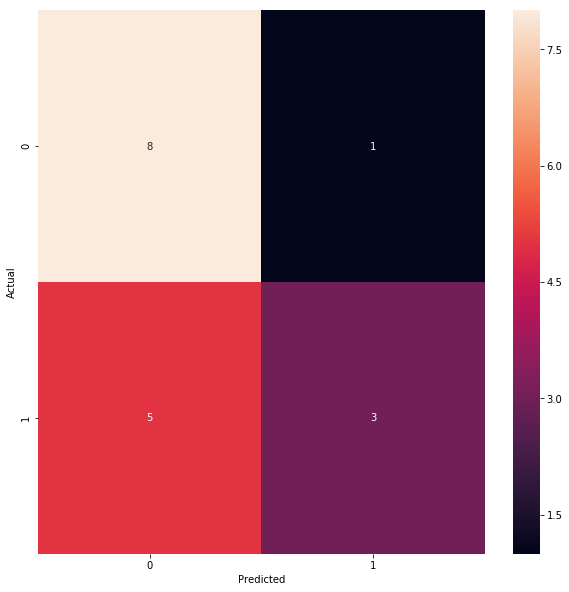

In [319]:
confusion_matrix= cm(y_test, predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

 - We used Stochastic gradient descent with logistic regression. Ridge regularization is used which is denoted by l2. The following hyperparameters generate the optimum results for this model. Log loss is representing logistic regression.

In [320]:
model= SGDClassifier(loss='log', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
model.fit(features_train, y_train)
predicted_svm = model.predict(features_test)
accuracy = model.score(features_test, y_test)
print(classification_report(predicted_svm,y_test))
error = mean_squared_error(y_test, predicted_svm)
print('Logistic Regression Accuracy',accuracy)
accuracies.append(accuracy)
print('MSE',error)

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.50      0.57      0.53         7

   micro avg       0.59      0.59      0.59        17
   macro avg       0.58      0.59      0.58        17
weighted avg       0.60      0.59      0.59        17

Logistic Regression Accuracy 0.5882352941176471
MSE 0.4117647058823529


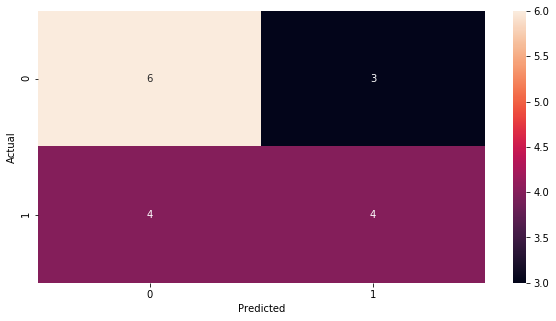

In [321]:
confusion_matrix= cm(y_test, predicted_svm)
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

##### Support Vector Machine
 - We trained linear SVM wit ridge regularization

In [322]:
model= SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
model.fit(features_train, y_train)
predicted_svm = model.predict(features_test)
print(classification_report(predicted_svm,y_test))
accuracy = model.score(features_test, y_test)
error = mean_squared_error(y_test, predicted_svm)
print('SVM Accuracy',accuracy)
print('MSE',error)
accuracies.append(accuracy)
# # Model Precision: what percentage of positive tuples are labeled as such?
# Model Recall: what percentage of positive tuples are labelled as such?

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.62      0.56      0.59         9

   micro avg       0.59      0.59      0.59        17
   macro avg       0.59      0.59      0.59        17
weighted avg       0.59      0.59      0.59        17

SVM Accuracy 0.5882352941176471
MSE 0.4117647058823529


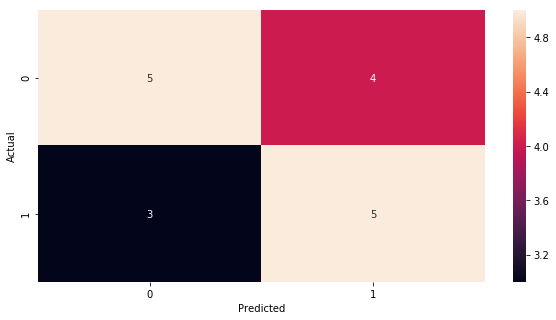

In [323]:
confusion_matrix= cm(y_test, predicted_svm)
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

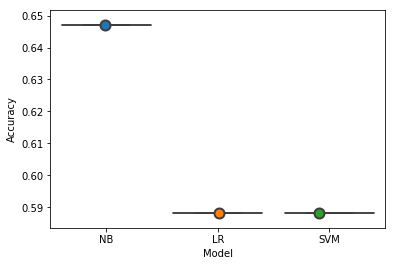

In [324]:
information = {'Model':models, 
        'Accuracy':accuracies}
data = pd.DataFrame(data=information)

sns.boxplot(x='Model', y='Accuracy', data=data)
sns.stripplot(x='Model', y='Accuracy', data=data, size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

 -  We can see from the above plot that NB performs the best among 3 models when feature vector is 
  bag of words

#### Data distribution

Text(0,0.5,'Count')

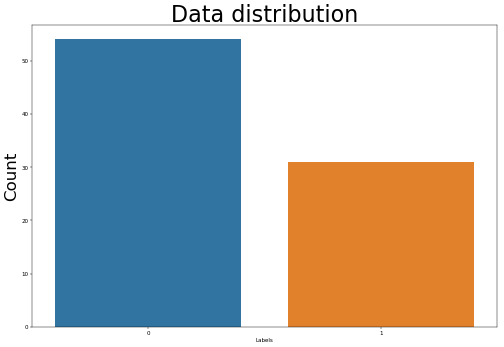

In [327]:
fig = plt.figure(figsize=(15,10), dpi=40)
sns.countplot(x="Labels", data=elections)
plt.title('Data distribution',fontsize = 40)
plt.ylabel('Count',fontsize = 30)

In [328]:
count_unbiased = len(elections[elections['Labels']==0])
count_biased = len(elections[elections['Labels']==1])
pct_of_unbiased = count_unbiased/(count_unbiased+count_biased)
print("percentage of unbiased", pct_of_unbiased*100)
pct_of_biased = count_biased /(count_unbiased+count_biased)
print("percentage of biased", pct_of_biased*100)

percentage of unbiased 63.52941176470588
percentage of biased 36.470588235294116


 - Our classes are imbalanced, and the ratio of unbiased to biased instances is 64:36. So we do oversampling and generate synthetic data to increase the number of samples in the dataset. We are basically increasing the minority class which is the biased class based upon the existing minority observations.
 - We first find the n-nearest neighbors in the minority class for each of the samples in the class . Then it draws a line between the the neighbors and generates random points on the lines.


In [329]:
print("Number of unbiased in original data",len(elections[elections['Labels']==0]))
print("Number of biased in original data",len(elections[elections['Labels']==1]))

Number of unbiased in original data 54
Number of biased in original data 31


 - We split the dataset to be used in oversampling

In [331]:
train, test = train_test_split(elections, test_size=0.2, random_state=42)
X_train = train['Content'].values
X_test = test['Content'].values
y_train = train['Labels']
y_test = test['Labels']
print('X_train',len(X_train))
print('X_test',len(X_test))
print('y_train',len(y_train))
print('y_test',len(X_test))

X_train 68
X_test 17
y_train 68
y_test 17


 - We use the same preprocessed dataset as before

In [334]:
from imblearn.over_sampling import SMOTE
# Use same preprocessing as previous
X = elections[['Content']]
y= elections.loc[:, elections.columns == 'Labels']
y =np.ravel(y)
os = SMOTE(ratio = 'minority')
bow = CountVectorizer(lowercase=True,analyzer = "word")
features_train = bow.fit_transform(X_train)
features_test = bow.transform(X_test)
os_data_X,os_data_y=os.fit_sample(features_train, y_train)
os_data_y= pd.DataFrame(data=os_data_y,columns=['Labels'])
print("length of oversampled data is ",len(os_data_y))
print("Number of unbiased in oversampled data",len(os_data_y[os_data_y['Labels']==0]))
print("Number of biased in oversampled data",len(os_data_y[os_data_y['Labels']==1]))

length of oversampled data is  90
Number of unbiased in oversampled data 45
Number of biased in oversampled data 45


In [335]:
X_train, X_test, y_train,y_test = train_test_split(os_data_X,os_data_y, test_size=0.2, random_state=42)

 - Now we have the balanced dataset.  
 - We now perform all the previous techniques using bag of words as feature vector and all previous models

In [340]:
model_test= SGDClassifier(loss='hinge', penalty='l1', alpha=1e-3, n_iter=5, random_state=42)
model_test.fit(X_train, y_train)
predicted_svm = model_test.predict(X_test)
print(classification_report(predicted_svm,y_test))
accuracy = model_test.score(X_test, y_test)
error = mean_squared_error(y_test, predicted_svm)
print('SVM Accuracy',accuracy)
print('MSE',error)
accuracies.append(accuracy)

C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\tooba\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.78      0.78      0.78         9

   micro avg       0.78      0.78      0.78        18
   macro avg       0.78      0.78      0.78        18
weighted avg       0.78      0.78      0.78        18

SVM Accuracy 0.7777777777777778
MSE 0.2222222222222222


 - We can now observe that our accuracy increased from 70% to 77% after oversampling the data. 
 - Without oversampling and using TDIF as feature vector we achieved best results with logistic regression and ridge regularization
 - With oversampling and using bag of words as feature vector we achieved best results with svm and lasso regularization

  -  We take the label corresponding to index 3 from our test data and check the input URL. 
  - We then feed the input url (in the form of features) to our model whuich predicts a label.
  - The model outputs articles which have an opposite label to the input URL. 

In [365]:
input_url = elections['Link'][70]
print('Input url',input_url)

Input url https://www.pakistantoday.com.pk/2018/01/15/shadow-of-uncertainty-looms-large-over-2018-general-elections-siraj/


In [367]:
predicted_label = model_test.predict(X_test[3])
true_label = y_test.iloc[3]
print('True label',true_label)
print('Predicted label',predicted_label)
filtered_data = elections[elections['Labels']!=1]
filtered_data = filtered_data[['Link','Labels']]
print('Length of returning data is:',len(filtered_data))
print('The following is the list of the returned article links')
filtered_data.head()

True label Labels    1
Name: 70, dtype: int64
Predicted label [1]
Length of returning data is: 54
The following is the list of the returned article links


,Link,Labels
0,https://www.pakistantoday.com.pk/2018/10/14/li...,0
1,https://www.pakistantoday.com.pk/2018/07/25/el...,0
10,https://www.pakistantoday.com.pk/2018/06/28/el...,0
11,https://www.pakistantoday.com.pk/2018/06/27/el...,0
12,https://www.pakistantoday.com.pk/2018/06/25/el...,0
